In [13]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from cmocean import cm

import warnings
warnings.filterwarnings("ignore")

In [14]:
grid = xr.open_dataset('/data1/parker/LO_data/grids/cas7/grid.nc')

In [15]:
def calc_stats(x, y):
    stats = {}
    MSE = np.nanmean((y - x)**2)
    stats['RMSE'] = np.sqrt(MSE)
    stats['bias'] = np.nanmean(y) - np.nanmean(x)
    stats['WSS'] = 1 - MSE / np.nanmean((abs(y - np.nanmean(x)) + abs(x - np.nanmean(x)))**2)
    
    return stats

def plot_panel(ax, x, y, lims, units):
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.2f} {units}\nbias = {stats['bias']:.2f} {units}\nWSS = {stats['WSS']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    c = ax.text(0, 0.8, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c


In [16]:
ctd2013 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2013.p')
ctd2014 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2014.p')
ctd2015 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2015.p')
ctd2016 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2016.p')
ctd2017 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2017.p')
ctd2018 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2018.p')
ctd2019 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_ctd_2019.p')


In [17]:
bot2013 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2013.p')
bot2014 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2014.p')
bot2015 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2015.p')
bot2016 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2016.p')
bot2017 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2017.p')
bot2018 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2018.p')
bot2019 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/cas7_t0_x4b/multi_bottle_2019.p')


In [18]:
obs = pd.concat([bot2013['obs'], bot2014['obs'], bot2015['obs'], bot2016['obs'], bot2017['obs'], bot2018['obs'], bot2019['obs']], ignore_index=True)
obs.name = 'bottle' # so that we can differentiate between bottle and ctd casts from dfo just in case
obs = pd.concat([obs,ctd2013['obs'], ctd2014['obs'], ctd2015['obs'], ctd2016['obs'], ctd2017['obs'], ctd2018['obs'], ctd2019['obs']], ignore_index=True)
obs.head()

,cid,lon,lat,time,z,SA,CT,DO (uM),NO3 (uM),Chl (mg m-3),name,cruise,source,NO2 (uM),NH4 (uM),PO4 (uM),SiO4 (uM),TA (uM),DIC (uM)
0,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-4.858567,29.526436,8.481087,217.480499,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-25.084826,29.931217,8.744595,194.705338,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-49.770050,30.161832,8.232655,199.617615,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-99.627083,31.185733,9.074455,7.145150,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-148.778397,31.455940,9.045912,5.805434,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# remove all unreasonable DO values, based on calculated max DO
obs.loc[obs['DO (uM)'] > 475, 'DO (uM)'] = pd.NA

# remove negative NO3 and Chl
obs.loc[obs['NO3 (uM)'] < 0, 'NO3 (uM)'] = pd.NA
obs.loc[obs['Chl (mg m-3)'] < 0, 'Chl (mg m-3)'] = pd.NA


Text(0, 0.5, 'Monthly count')

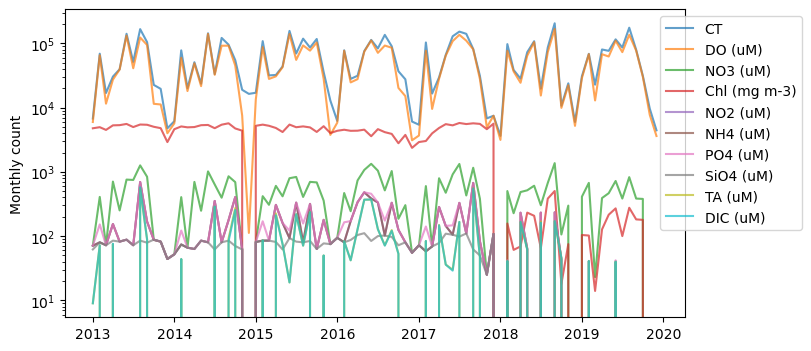

In [21]:
# lets see how the count of data changes with time, seperated by what was measured
# Extract both month and year from the 'time' column
obs['year_month'] = obs['time'].dt.to_period('M')  # This creates a Period object 'YYYY-MM'
obs['year_month'] = obs['year_month'].dt.to_timestamp()

# Columns to count non-NaN entries
columns_to_count = [
    'SA', 'CT', 'DO (uM)', 'NO3 (uM)', 'Chl (mg m-3)', 'NO2 (uM)', 
    'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)', 'DIC (uM)'
]

# Group by 'year_month' and count non-NaN entries for each column
monthly_counts = obs.groupby('year_month')[columns_to_count].count()

# plot
fig, ax = plt.subplots(1,1,figsize=[8,4])

for var in monthly_counts.columns[1:]:
    ax.plot(monthly_counts.index, monthly_counts[var], label=var,alpha=0.7)

ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.2, 1.0))
ax.set_ylabel('Monthly count')


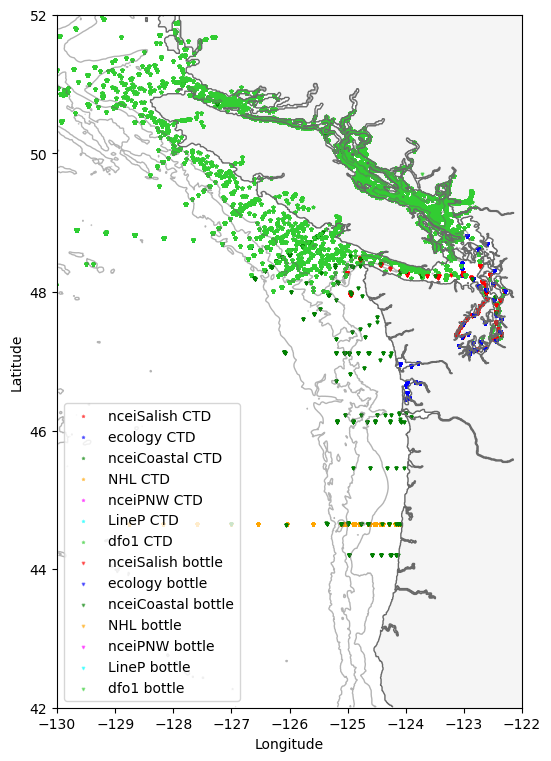

In [ ]:
# plot by source
fig, ax = plt.subplots(1,1,figsize=(6, 9))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])


# plot the location of observations
clist = ['r','b','g','orange','magenta','cyan','limegreen']
k=0
for source in list(set(obs.source)):
    ax.scatter(obs.lon[(obs.source==source) & (obs.name != 'bottle')], obs.lat[(obs.source==source) & (obs.name != 'bottle')], s=3, marker='*', color=clist[k], alpha=0.5, label="{} CTD".format(source))
    k+=1
k=0
for source in list(set(obs.source)):
    ax.scatter(obs.lon[(obs.source==source) & (obs.name == 'bottle')], obs.lat[(obs.source==source) & (obs.name == 'bottle')], marker='v',s=3, color=clist[k], alpha=0.5, label="{} bottle".format(source))
    k+=1
ax.legend(fontsize=10)


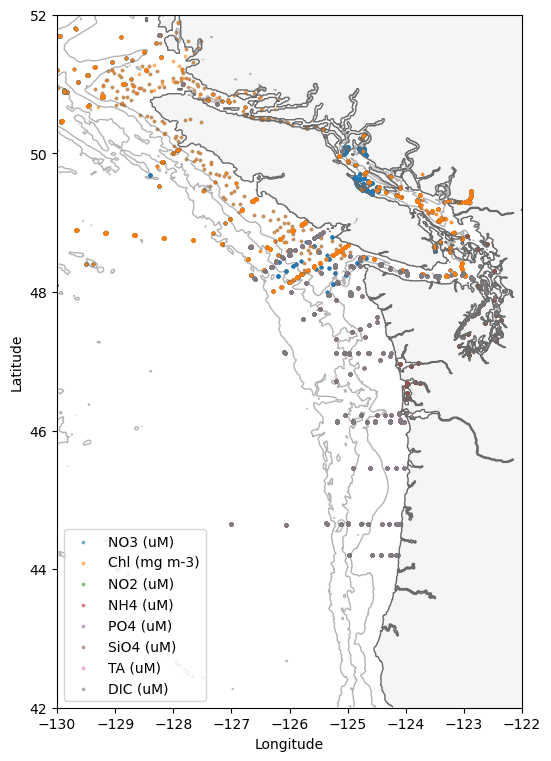

In [35]:
# plot by tracer (except SA and CT)
fig, ax = plt.subplots(1,1,figsize=(6, 9))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])


# plot the location of observations
tracers = ['NO3 (uM)', 'Chl (mg m-3)', 'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)', 'DIC (uM)']
k=0
for t in tracers:
    ax.scatter(obs.lon[~np.isnan(obs[t])], obs.lat[~np.isnan(obs[t])], s=3, alpha=0.5, label=t)
    k+=1
k=0
ax.legend()

In [ ]:
mod = pd.concat([bot2013['cas7_t0_x4b'], bot2014['cas7_t0_x4b'], bot2015['cas7_t0_x4b'], bot2016['cas7_t0_x4b'], bot2017['cas7_t0_x4b'], bot2018['cas7_t0_x4b'],bot2019['cas7_t0_x4b']], ignore_index=True)
mod.name = 'bottle' # so that we can differentiate between bottle and ctd casts from dfo just in case
mod = pd.concat([mod,ctd2013['cas7_t0_x4b'], ctd2014['cas7_t0_x4b'], ctd2015['cas7_t0_x4b'], ctd2016['cas7_t0_x4b'], ctd2017['cas7_t0_x4b'], ctd2018['cas7_t0_x4b'], ctd2019['cas7_t0_x4b']], ignore_index=True)
mod.head()

,cid,cruise,time,lat,lon,name,z,source,h,CT,SA,Chl (mg m-3),DO (uM),NO3 (uM),NO2 (uM),NH4 (uM),TA (uM),DIC (uM)
0,0.0,NaN,2013-02-06 03:32:28,48.593334,-123.500336,bottle,-4.858567,dfo1,172.824,7.463596,28.046377,0.022344,268.725586,22.274712,NaN,0.031271,2037.990356,1959.521118
1,0.0,NaN,2013-02-06 03:32:28,48.593334,-123.500336,bottle,-25.084826,dfo1,172.824,8.601436,29.419864,0.003724,233.922440,23.146416,NaN,0.013879,2114.631836,2037.126221
2,0.0,NaN,2013-02-06 03:32:28,48.593334,-123.500336,bottle,-49.770050,dfo1,172.824,8.905677,30.064023,0.002670,209.733170,23.892056,NaN,0.011508,2147.557129,2075.040283
3,0.0,NaN,2013-02-06 03:32:28,48.593334,-123.500336,bottle,-99.627083,dfo1,172.824,8.914655,30.125749,0.002726,207.064545,23.977772,NaN,0.012508,2149.803711,2078.231689
4,0.0,NaN,2013-02-06 03:32:28,48.593334,-123.500336,bottle,-148.778397,dfo1,172.824,8.660801,30.113303,0.003090,218.088181,23.586140,NaN,0.027075,2149.161865,2074.113037


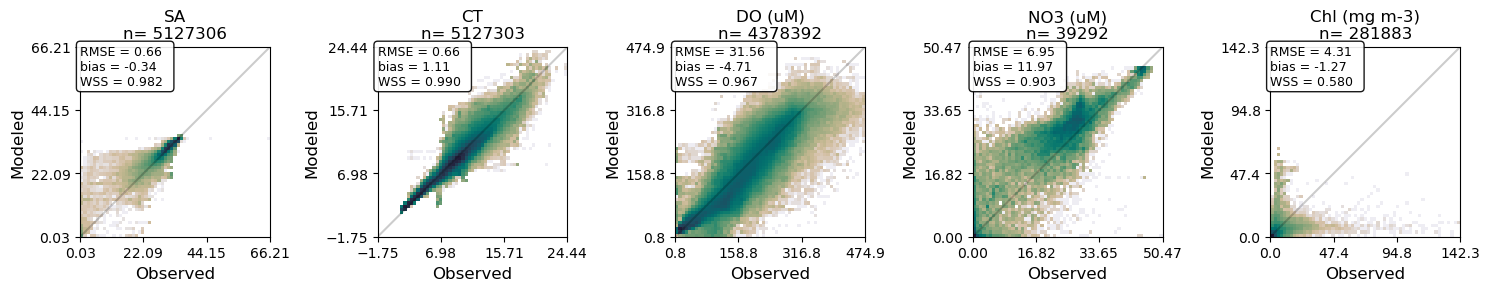

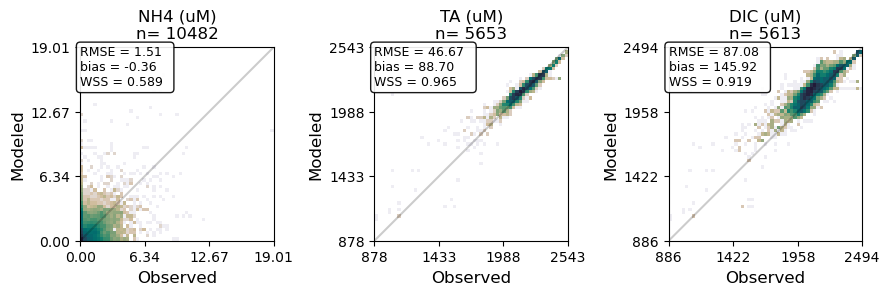

In [30]:
# eval over entire model domain
tracers = ['SA', 'CT', 'DO (uM)', 'NO3 (uM)', 'Chl (mg m-3)',] 

cmap = cm.rain

fig, axs = plt.subplots(1, len(tracers), figsize = (3*len(tracers), 3)) 

for i in range(len(tracers)):
    vmin, vmax = np.min(obs[tracers[i]]), np.max(obs[tracers[i]])
    bin = np.linspace(vmin,vmax,60)

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracers[i]]))&(~np.isnan(mod[tracers[i]]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs.loc[iiS,[tracers[i]]].values.flatten(),
                                        mod.loc[iiS,[tracers[i]]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin, vmax, 4)
    # axs[i].set_xlim((27,35))
    # axs[i].set_ylim((27,35))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracers[i]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracers[i]])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracers[i]], mod[tracers[i]], (vmin,vmax), ' ')

plt.tight_layout()

tracers = ['NH4 (uM)', 'TA (uM)', 'DIC (uM)']
fig, axs = plt.subplots(1, len(tracers), figsize = (3*len(tracers), 3)) 

for i in range(len(tracers)):
    vmin, vmax = np.min(obs[tracers[i]]), np.max(obs[tracers[i]])
    bin = np.linspace(vmin,vmax,60)

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracers[i]]))&(~np.isnan(mod[tracers[i]]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs.loc[iiS,[tracers[i]]].values.flatten(),
                                        mod.loc[iiS,[tracers[i]]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin, vmax, 4)
    # axs[i].set_xlim((27,35))
    # axs[i].set_ylim((27,35))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracers[i]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracers[i]])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracers[i]], mod[tracers[i]], (vmin,vmax), ' ')

plt.tight_layout()

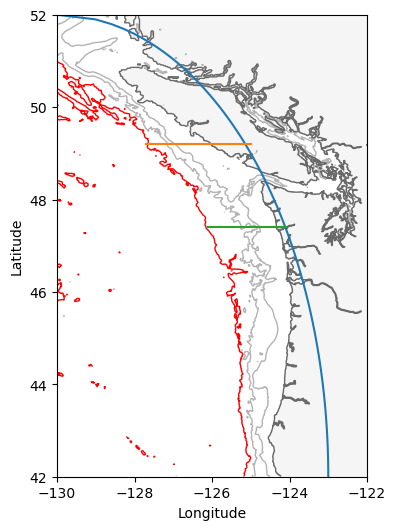

In [22]:
grid = xr.open_dataset('/data1/parker/LO_data/grids/cas6/grid.nc')

fig, ax = plt.subplots(1,1,figsize=(4, 6))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000], colors='dimgray', alpha=0.5)
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[2000], colors='r')

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])

# salish sea cuttoff
y=np.linspace(42,52,100)
x = np.sqrt((1-((y-42)**2)/(10**2))*(7**2))-130
ax.plot(x,y)

#north cuttoff
ax.plot([-127.7,-125],[49.2,49.2])

# south cuttoff
ax.plot([-126.1,-124.1],[47.4,47.4])

In [23]:
ny = 49.2
sy = 47.4
d = 2000

# code for seperating observations into groups based on location and depth
def region(lat,lon,d):
    if d >= 2000:
        return 1 #offshore
    elif lon > np.sqrt((1-(((lat-42)**2)/(10**2)))*(7**2))-130 and lat < 51:
        return 2 #salish sea
    elif lat > ny:
        return 3 #north
    elif lat < sy:
        return 4 #south
    else:
        return 5 #domain


In [24]:
regions = ['Offshore', 'Salish Sea', 'North', 'South', 'Domain']
obs['region'] = [region(obs.lat[i],obs.lon[i],mod.h[i]) for i in range(len(obs))]
mod['region'] = obs.region


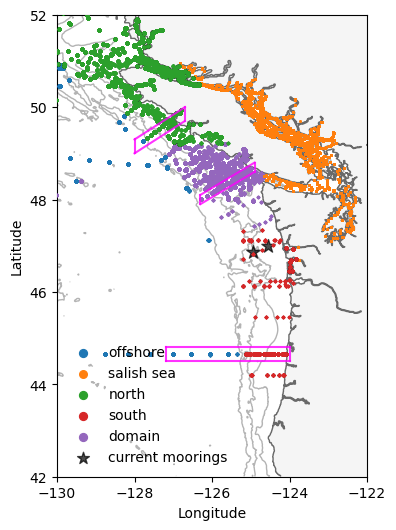

In [25]:
# quick visual check to see if seperated properly
fig, ax = plt.subplots(1,1,figsize=(4, 6))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke',zorder=1)
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray', zorder=2)
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5, zorder=0)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])


# plot the location of observations
ax.scatter(obs.lon[obs.region == 1], obs.lat[obs.region == 1], s=2, label="offshore",zorder=4)
ax.scatter(obs.lon[obs.region == 2], obs.lat[obs.region == 2], s=1, label="salish sea",zorder=4)
ax.scatter(obs.lon[obs.region == 3], obs.lat[obs.region == 3], s=2, label="north",zorder=4)
ax.scatter(obs.lon[obs.region == 4], obs.lat[obs.region == 4], s=2, label="south",zorder=4)
ax.scatter(obs.lon[obs.region == 5], obs.lat[obs.region == 5], s=2, label="domain",zorder=3)


# plot lil boxes around areas that you compare in crosssections.ipynb
#newport line?
plt.plot([-127.2,-124],[44.8,44.8],c='magenta',alpha=0.8,zorder=5)
plt.plot([-127.2,-124],[44.5,44.5],c='magenta',alpha=0.8,zorder=5)
plt.plot([-127.2,-127.2],[44.8,44.5],c='magenta',alpha=0.8,zorder=5)
plt.plot([-124,-124],[44.8,44.5],c='magenta',alpha=0.8,zorder=5)

#nice lil line near jdf entrance
plt.plot([-126.3,-126.3],[47.9,48.1],c='magenta',alpha=0.8,zorder=5)
plt.plot([-124.9,-124.9],[48.6,48.8],c='magenta',alpha=0.8,zorder=5)
plt.plot([-126.3,-124.9],[48.1,48.8],c='magenta',alpha=0.8,zorder=5)
plt.plot([-124.9,-126.3],[48.6,47.9],c='magenta',alpha=0.8,zorder=5)

#nice lil line a bit further up north
plt.plot([-128,-126.7],[49,49.7],c='magenta',alpha=0.8,zorder=5)
plt.plot([-128,-126.7],[49.3,50],c='magenta',alpha=0.8,zorder=5)
plt.plot([-126.7,-126.7],[49.7,50],c='magenta',alpha=0.8,zorder=5)
plt.plot([-128,-128],[49,49.3],c='magenta',alpha=0.8,zorder=5)

# make the markers for the stations in the timeseries analysis larger
plt.scatter([-124.56362,-124.9504],[46.98767,46.8545],c='k',s=100,marker='*',alpha=0.7, label="current moorings",zorder=3) 

lgnd= ax.legend(loc='lower left', markerscale=4, frameon=False)
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[5]._sizes = [80]

In [26]:
# print the count of each
print(len(obs[obs.region == 1]), " = count offshore")
print(len(obs[obs.region == 2]), " = count salish sea")
print(len(obs[obs.region == 3]), " = count north")
print(len(obs[obs.region == 4]), " = count south")
print(len(obs[obs.region == 5]), " = count domain")

822535  = count offshore
1335750  = count salish sea
1729331  = count north
140265  = count south
1105351  = count domain


# Observations versus model

Evaluation of LiveOcean salinity compared to all DFO CTD casts (2017-2021) by region:


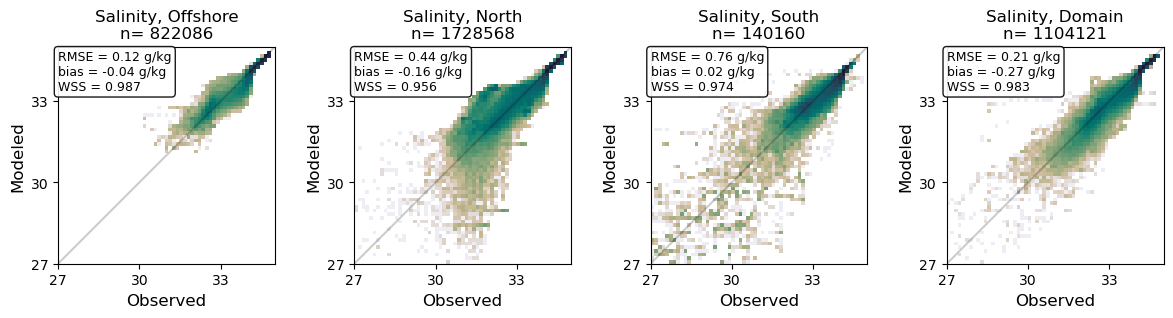

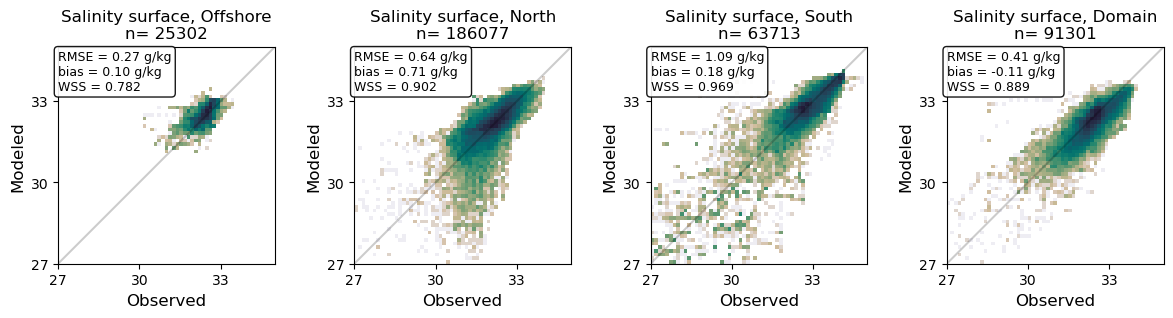

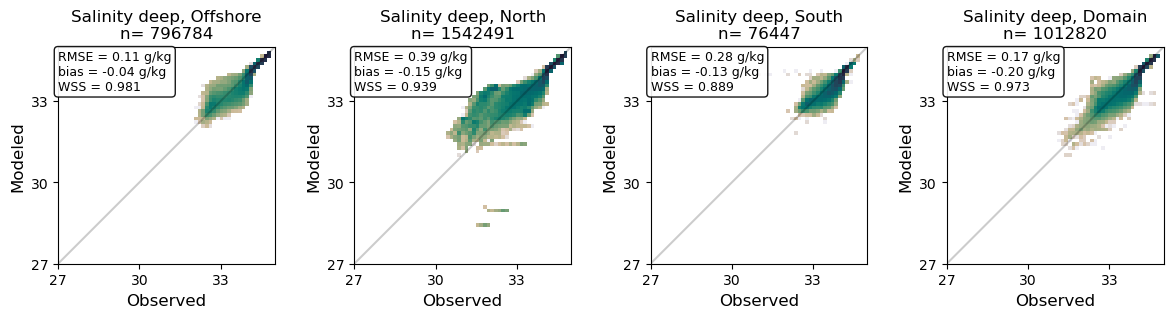

In [38]:
# evals of salinity by region
vmin, vmax = 27, 35
bin = np.linspace(vmin,vmax,60)

cmap = cm.rain

fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs.SA[obs.region == r]))&(~np.isnan(mod.SA[mod.region == r]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[obs.region == r].loc[iiS,['SA']].values.flatten(),
                                        mod[mod.region == r].loc[iiS,['SA']].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(27, 35, 3)
    axs[i].set_xlim((27,35))
    axs[i].set_ylim((27,35))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'Salinity, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs.SA[(obs.region == r)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs['SA'][obs.region == r], mod['SA'][mod.region == r], (27,35), 'g/kg')

plt.tight_layout()

# at the surface (top 50 m)
d = -50
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs.SA[(obs.region == r) & (obs.z > d)]))&(~np.isnan(mod.SA[(mod.region == r) & (mod.z > d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[(obs.region == r) & (obs.z > d)].loc[iiS,['SA']].values.flatten(),
                                        mod[(mod.region == r) & (mod.z > d)].loc[iiS,['SA']].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(27, 35, 3)
    axs[i].set_xlim((27,35))
    axs[i].set_ylim((27,35))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'Salinity surface, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs.SA[(obs.region == r) & (obs.z > d)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs['SA'][(obs.region == r) & (obs.z > d)], mod['SA'][(mod.region == r) & (mod.z > d)], (27,35), 'g/kg')

plt.tight_layout()

# deep (below 50 m)
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs.SA[(obs.region == r) & (obs.z <= d)]))&(~np.isnan(mod.SA[(mod.region == r) & (mod.z <= d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[(obs.region == r) & (obs.z <= d)].loc[iiS,['SA']].values.flatten(),
                                        mod[(mod.region == r) & (mod.z <= d)].loc[iiS,['SA']].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(27, 35, 3)
    axs[i].set_xlim((27,35))
    axs[i].set_ylim((27,35))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'Salinity deep, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs.SA[(obs.region == r) & (obs.z <= d)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs['SA'][(obs.region == r) & (obs.z <= d)], mod['SA'][(mod.region == r) & (mod.z <= d)], (27,35), 'g/kg')

plt.tight_layout()


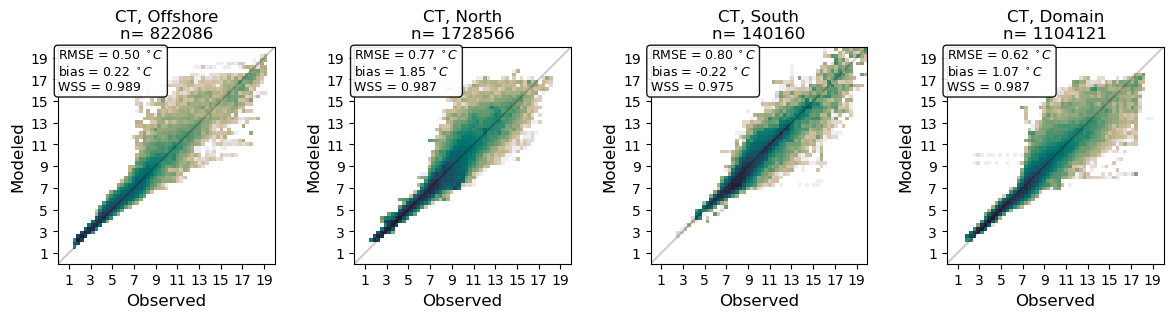

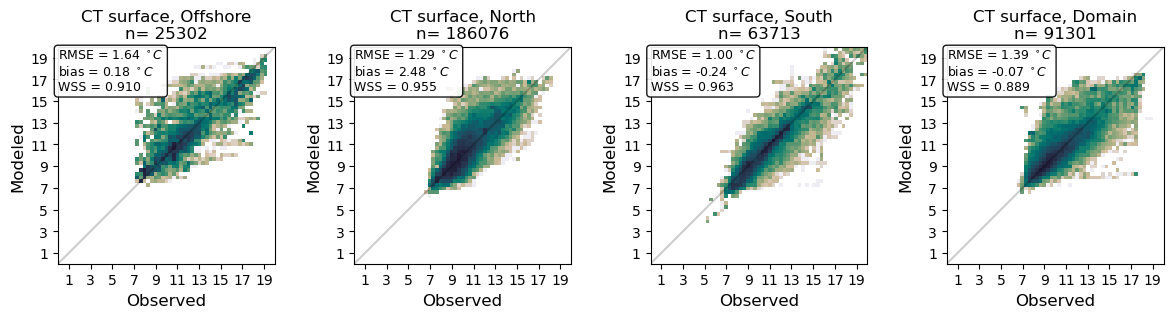

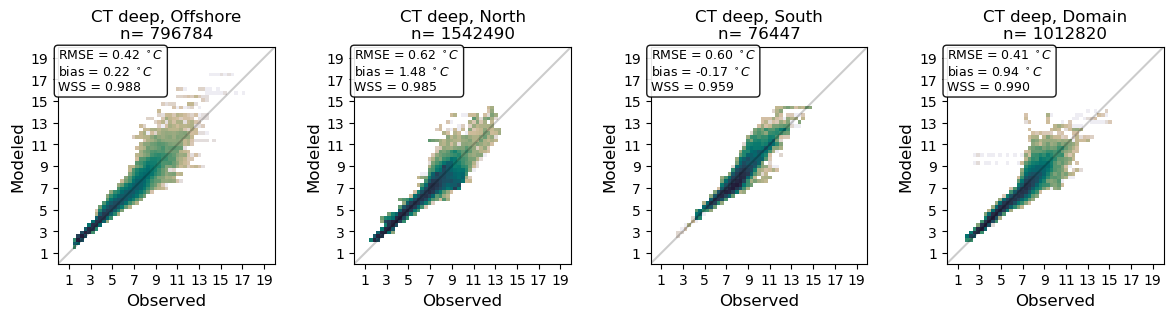

In [39]:
# evals of temperature by region
vmin, vmax = 0, 20
bin = np.linspace(vmin,vmax,60)

cmap = cm.rain

fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)


    iiS=(~np.isnan(obs.CT[obs.region == r]))&(~np.isnan(mod.CT[mod.region == r]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[obs.region == r].loc[iiS,['CT']].values.flatten(),
                                        mod[mod.region == r].loc[iiS,['CT']].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(1, 21, 2)
    axs[i].set_xlim((0,20))
    axs[i].set_ylim((0,20))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'CT, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs.CT[(obs.region == r)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs['CT'][obs.region == r], mod['CT'][mod.region == r], (0,20), '$^\circ C$')

plt.tight_layout()

# at the surface (top 50 m)
d = -50
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)


    iiS=(~np.isnan(obs.CT[(obs.region == r) & (obs.z > d)]))&(~np.isnan(mod.CT[(mod.region == r) & (mod.z > d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[(obs.region == r) & (obs.z > d)].loc[iiS,['CT']].values.flatten(),
                                        mod[(mod.region == r) & (mod.z > d)].loc[iiS,['CT']].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(1, 21, 2)
    axs[i].set_xlim((0,20))
    axs[i].set_ylim((0,20))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'CT surface, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs.CT[(obs.region == r) & (obs.z > d)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs['CT'][(obs.region == r) & (obs.z > d)], mod['CT'][(mod.region == r) & (mod.z > d)], (0,20), '$^\circ C$')

plt.tight_layout()

# deep (below 50 m)
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)


    iiS=(~np.isnan(obs.CT[(obs.region == r) & (obs.z <= d)]))&(~np.isnan(mod.CT[(mod.region == r) & (mod.z <= d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[(obs.region == r) & (obs.z <= d)].loc[iiS,['CT']].values.flatten(),
                                        mod[(mod.region == r) & (mod.z <= d)].loc[iiS,['CT']].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(1, 21, 2)
    axs[i].set_xlim((0,20))
    axs[i].set_ylim((0,20))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'CT deep, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs.CT[(obs.region == r) & (obs.z <= d)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs['CT'][(obs.region == r) & (obs.z <= d)], mod['CT'][(mod.region == r) & (mod.z <= d)], (0,20), '$^\circ C$')

plt.tight_layout()


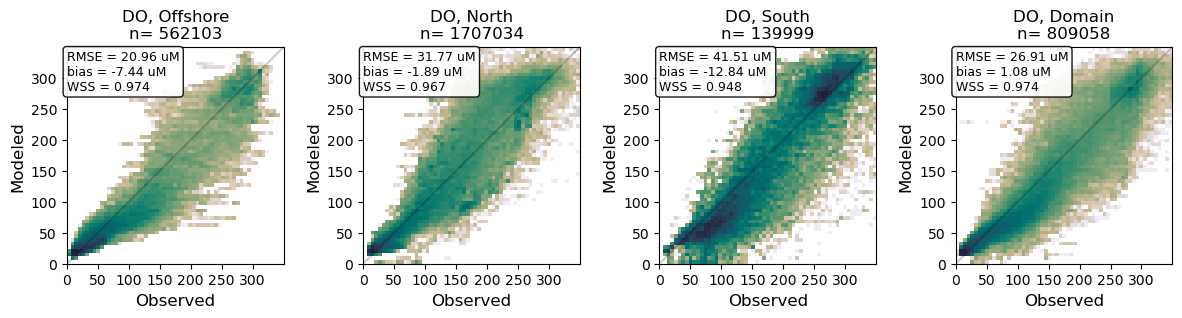

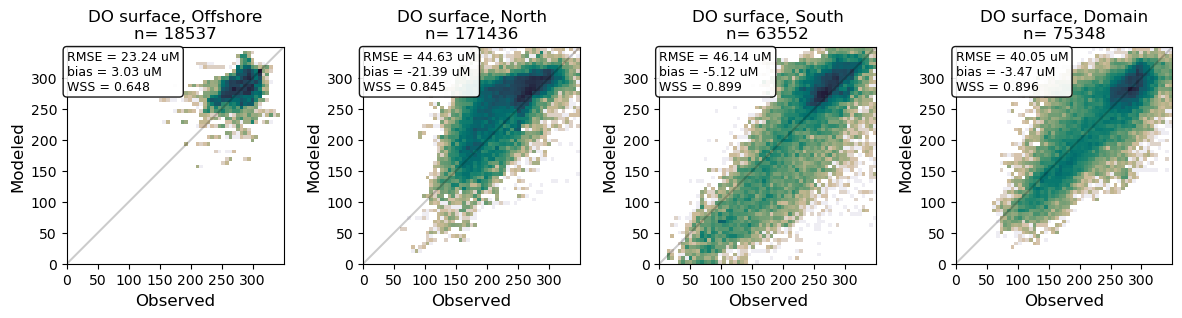

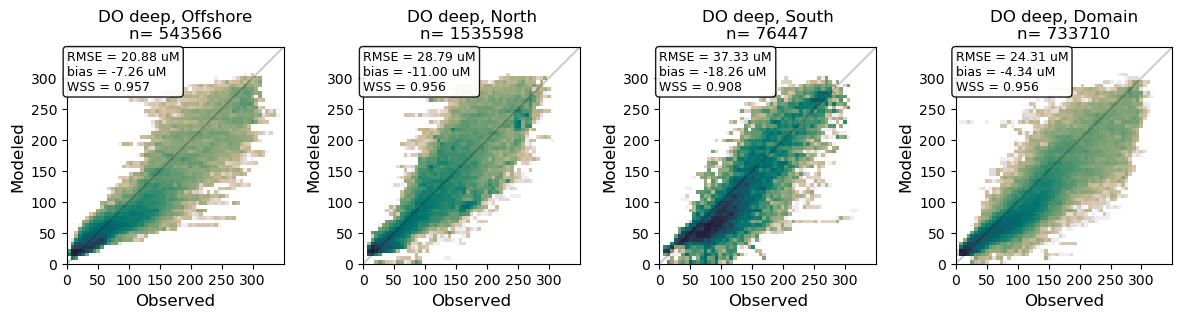

In [40]:
# evals of DO by region
vmin, vmax = 0, 350
bin = np.linspace(vmin,vmax,60)

cmap = cm.rain

fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)


    iiS=(~np.isnan(obs['DO (uM)'][obs.region == r]))&(~np.isnan(mod['DO (uM)'][mod.region == r]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[obs.region == r].loc[iiS,['DO (uM)']].values.flatten(),
                                        mod[mod.region == r].loc[iiS,['DO (uM)']].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(0,350, 50)
    axs[i].set_xlim((0,350))
    axs[i].set_ylim((0,350))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'DO, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs['DO (uM)'][(obs.region == r)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs['DO (uM)'][obs.region == r], mod['DO (uM)'][mod.region == r], (0,350), 'uM')

plt.tight_layout()

# at the surface (top 50 m)
d = -50
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)


    iiS=(~np.isnan(obs['DO (uM)'][(obs.region == r) & (obs.z > d)]))&(~np.isnan(mod['DO (uM)'][(mod.region == r) & (mod.z > d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[(obs.region == r) & (obs.z > d)].loc[iiS,['DO (uM)']].values.flatten(),
                                        mod[(mod.region == r) & (mod.z > d)].loc[iiS,['DO (uM)']].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(0,350, 50)
    axs[i].set_xlim((0,350))
    axs[i].set_ylim((0,350))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'DO surface, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs['DO (uM)'][(obs.region == r) & (obs.z > d)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs['DO (uM)'][(obs.region == r) & (obs.z > d)], mod['DO (uM)'][(mod.region == r) & (mod.z > d)], (0,350), 'uM')

plt.tight_layout()

# deep (below 50 m)
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)


    iiS=(~np.isnan(obs['DO (uM)'][(obs.region == r) & (obs.z <= d)]))&(~np.isnan(mod['DO (uM)'][(mod.region == r) & (mod.z <= d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[(obs.region == r) & (obs.z <= d)].loc[iiS,['DO (uM)']].values.flatten(),
                                        mod[(mod.region == r) & (mod.z <= d)].loc[iiS,['DO (uM)']].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.arange(0,350, 50)
    axs[i].set_xlim((0,350))
    axs[i].set_ylim((0,350))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = 'DO deep, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs['DO (uM)'][(obs.region == r) & (obs.z <= d)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs['DO (uM)'][(obs.region == r) & (obs.z <= d)], mod['DO (uM)'][(mod.region == r) & (mod.z <= d)], (0,350), 'uM')

plt.tight_layout()


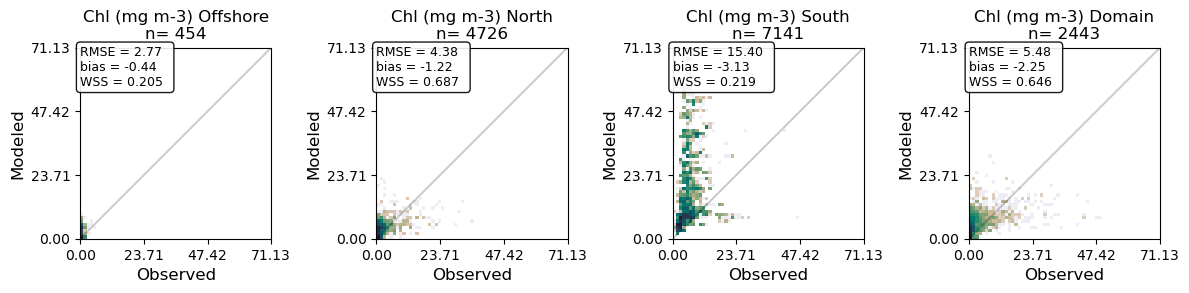

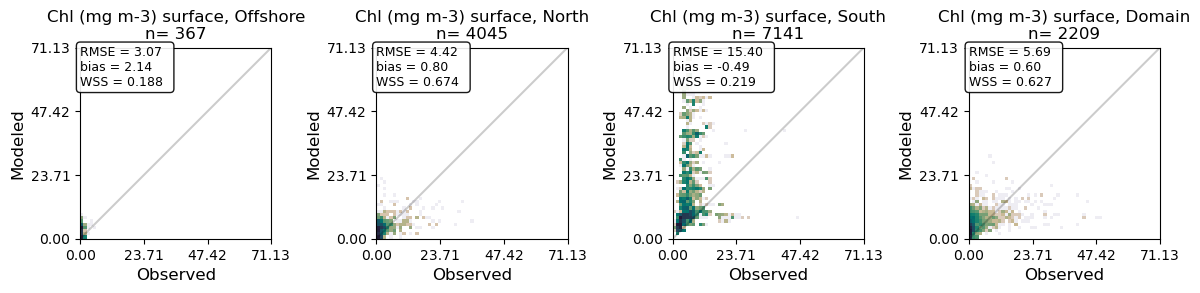

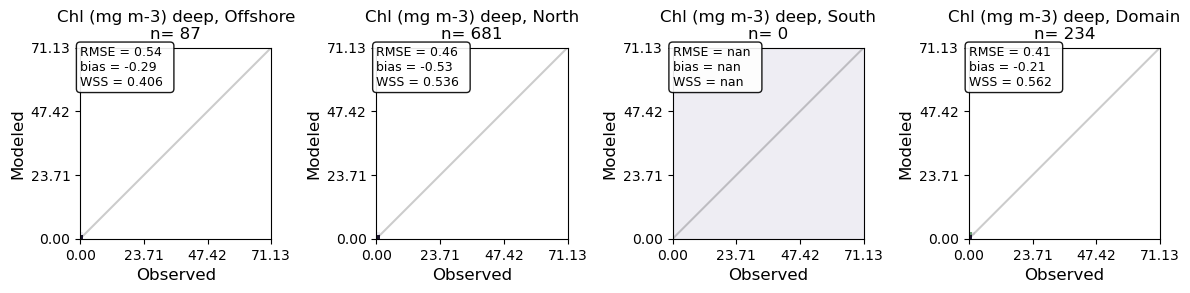

In [43]:
# evals of Chl
tracer = 'Chl (mg m-3)'
vmin, vmax = np.min(obs[tracer]), np.max(obs[tracer])*0.5
bin = np.linspace(vmin,vmax,60)

cmap = cm.rain

fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1):

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracer][obs.region == r]))&(~np.isnan(mod[tracer][mod.region == r]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[obs.region == r].loc[iiS,[tracer]].values.flatten(),
                                        mod[mod.region == r].loc[iiS,[tracer]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin,vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracer+' '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracer][(obs.region == r)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracer][obs.region == r], mod[tracer][mod.region == r], (vmin,vmax), ' ')

plt.tight_layout()

# at the surface (top 50 m)
d = -50
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)


    iiS=(~np.isnan(obs[tracer][(obs.region == r) & (obs.z > d)]))&(~np.isnan(mod[tracer][(mod.region == r) & (mod.z > d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[(obs.region == r) & (obs.z > d)].loc[iiS,[tracer]].values.flatten(),
                                        mod[(mod.region == r) & (mod.z > d)].loc[iiS,[tracer]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin,vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracer+' surface, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracer][(obs.region == r) & (obs.z > d)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracer][(obs.region == r) & (obs.z > d)], mod[tracer][(mod.region == r) & (mod.z > d)], (vmin,vmax), ' ')

plt.tight_layout()

# deep (below 50 m)
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)


    iiS=(~np.isnan(obs[tracer][(obs.region == r) & (obs.z <= d)]))&(~np.isnan(mod[tracer][(mod.region == r) & (mod.z <= d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[(obs.region == r) & (obs.z <= d)].loc[iiS,[tracer]].values.flatten(),
                                        mod[(mod.region == r) & (mod.z <= d)].loc[iiS,[tracer]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin,vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracer+' deep, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracer][(obs.region == r) & (obs.z <= d)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracer][(obs.region == r) & (obs.z <= d)], mod[tracer][(mod.region == r) & (mod.z <= d)], (vmin,vmax), ' ')

plt.tight_layout()


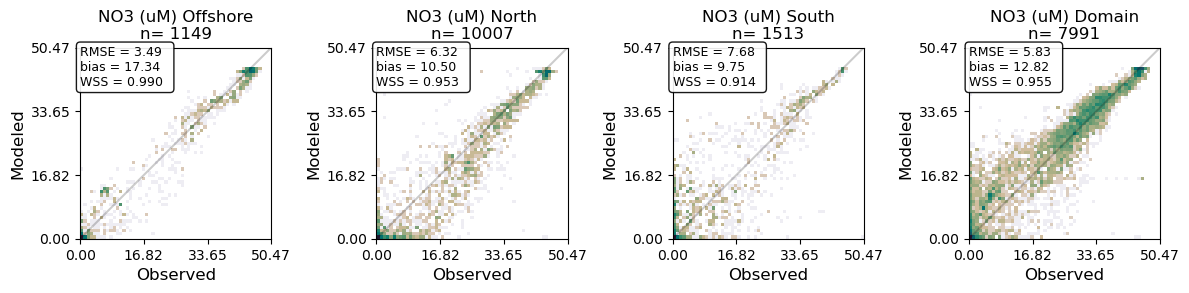

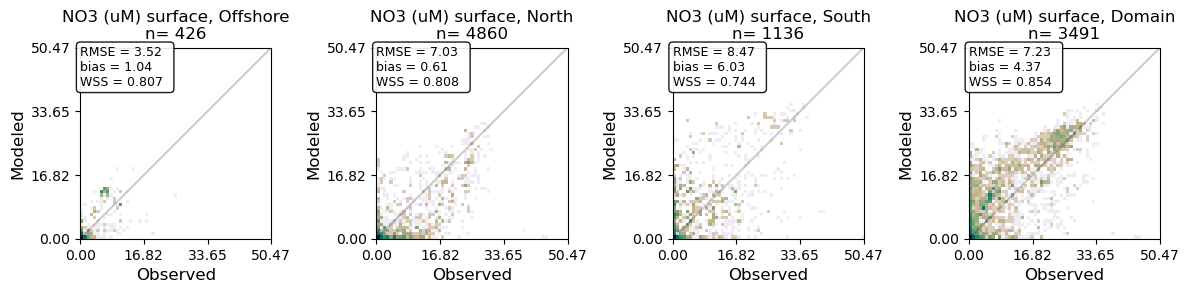

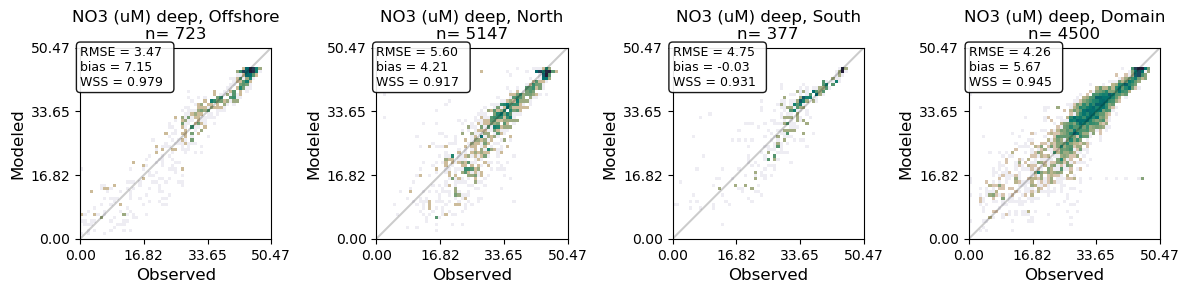

In [45]:
# evals of NO3
tracer = 'NO3 (uM)'
vmin, vmax = np.min(obs[tracer]), np.max(obs[tracer])
bin = np.linspace(vmin,vmax,60)

cmap = cm.rain

fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1):

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracer][obs.region == r]))&(~np.isnan(mod[tracer][mod.region == r]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[obs.region == r].loc[iiS,[tracer]].values.flatten(),
                                        mod[mod.region == r].loc[iiS,[tracer]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin,vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracer+' '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracer][(obs.region == r)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracer][obs.region == r], mod[tracer][mod.region == r], (vmin,vmax), ' ')

plt.tight_layout()

# at the surface (top 50 m)
d = -50
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)


    iiS=(~np.isnan(obs[tracer][(obs.region == r) & (obs.z > d)]))&(~np.isnan(mod[tracer][(mod.region == r) & (mod.z > d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[(obs.region == r) & (obs.z > d)].loc[iiS,[tracer]].values.flatten(),
                                        mod[(mod.region == r) & (mod.z > d)].loc[iiS,[tracer]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin,vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracer+' surface, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracer][(obs.region == r) & (obs.z > d)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracer][(obs.region == r) & (obs.z > d)], mod[tracer][(mod.region == r) & (mod.z > d)], (vmin,vmax), ' ')

plt.tight_layout()

# deep (below 50 m)
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)


    iiS=(~np.isnan(obs[tracer][(obs.region == r) & (obs.z <= d)]))&(~np.isnan(mod[tracer][(mod.region == r) & (mod.z <= d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[(obs.region == r) & (obs.z <= d)].loc[iiS,[tracer]].values.flatten(),
                                        mod[(mod.region == r) & (mod.z <= d)].loc[iiS,[tracer]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin,vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracer+' deep, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracer][(obs.region == r) & (obs.z <= d)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracer][(obs.region == r) & (obs.z <= d)], mod[tracer][(mod.region == r) & (mod.z <= d)], (vmin,vmax), ' ')

plt.tight_layout()

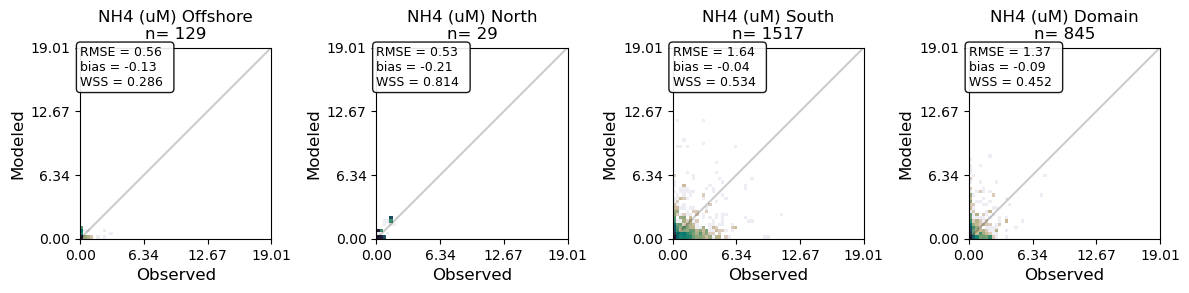

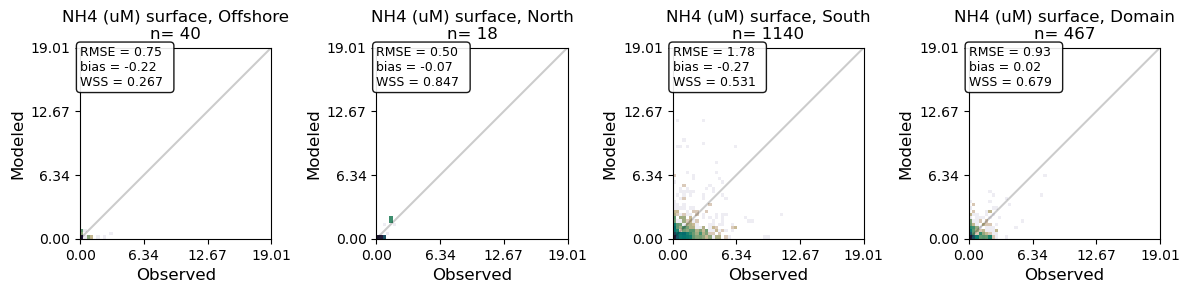

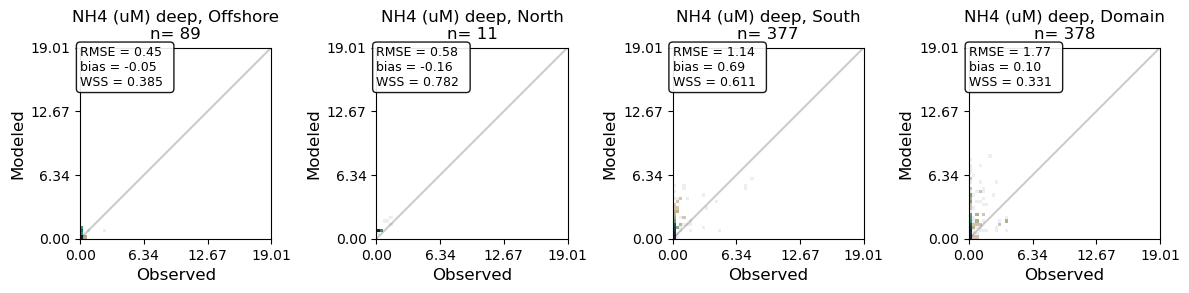

In [46]:
# evals of NH4
tracer = 'NH4 (uM)'
vmin, vmax = np.min(obs[tracer]), np.max(obs[tracer])
bin = np.linspace(vmin,vmax,60)

cmap = cm.rain

fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1):

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracer][obs.region == r]))&(~np.isnan(mod[tracer][mod.region == r]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[obs.region == r].loc[iiS,[tracer]].values.flatten(),
                                        mod[mod.region == r].loc[iiS,[tracer]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin,vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracer+' '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracer][(obs.region == r)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracer][obs.region == r], mod[tracer][mod.region == r], (vmin,vmax), ' ')

plt.tight_layout()

# at the surface (top 50 m)
d = -50
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)


    iiS=(~np.isnan(obs[tracer][(obs.region == r) & (obs.z > d)]))&(~np.isnan(mod[tracer][(mod.region == r) & (mod.z > d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[(obs.region == r) & (obs.z > d)].loc[iiS,[tracer]].values.flatten(),
                                        mod[(mod.region == r) & (mod.z > d)].loc[iiS,[tracer]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin,vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracer+' surface, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracer][(obs.region == r) & (obs.z > d)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracer][(obs.region == r) & (obs.z > d)], mod[tracer][(mod.region == r) & (mod.z > d)], (vmin,vmax), ' ')

plt.tight_layout()

# deep (below 50 m)
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)


    iiS=(~np.isnan(obs[tracer][(obs.region == r) & (obs.z <= d)]))&(~np.isnan(mod[tracer][(mod.region == r) & (mod.z <= d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[(obs.region == r) & (obs.z <= d)].loc[iiS,[tracer]].values.flatten(),
                                        mod[(mod.region == r) & (mod.z <= d)].loc[iiS,[tracer]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin,vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracer+' deep, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracer][(obs.region == r) & (obs.z <= d)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracer][(obs.region == r) & (obs.z <= d)], mod[tracer][(mod.region == r) & (mod.z <= d)], (vmin,vmax), ' ')

plt.tight_layout()

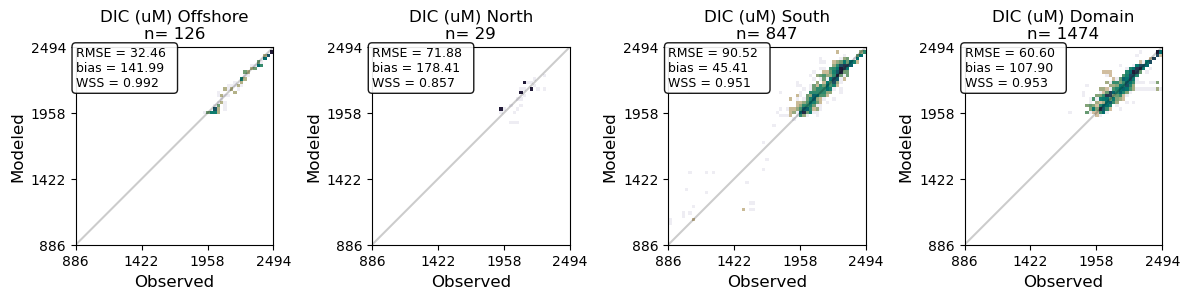

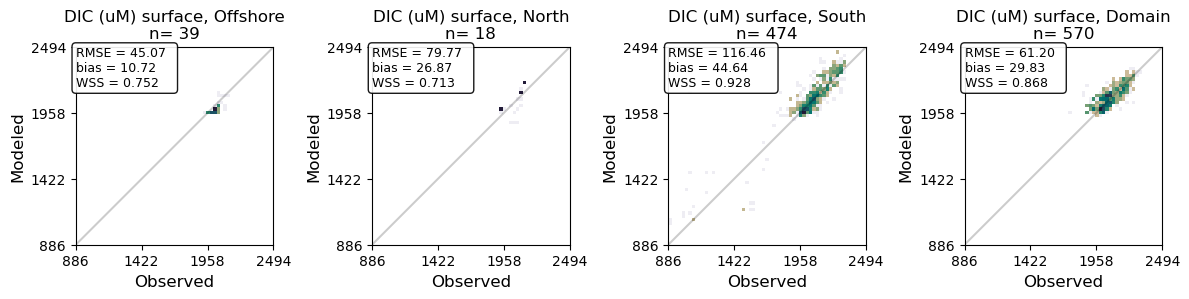

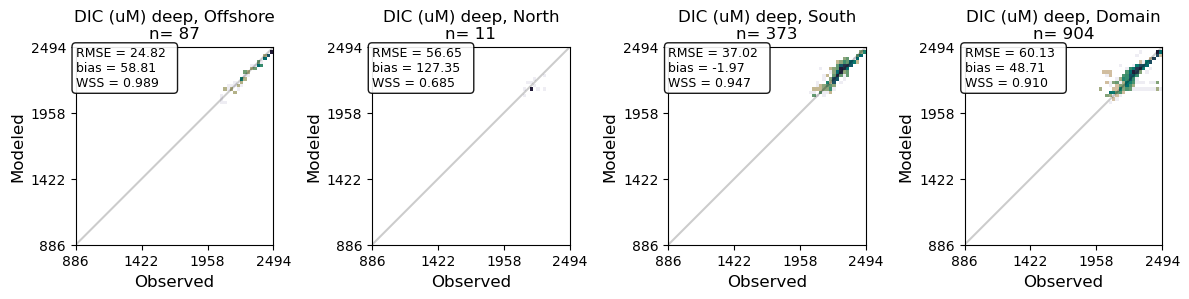

In [47]:
# evals of DIC
tracer = 'DIC (uM)'
vmin, vmax = np.min(obs[tracer]), np.max(obs[tracer])
bin = np.linspace(vmin,vmax,60)

cmap = cm.rain

fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1):

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)

    iiS=(~np.isnan(obs[tracer][obs.region == r]))&(~np.isnan(mod[tracer][mod.region == r]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[obs.region == r].loc[iiS,[tracer]].values.flatten(),
                                        mod[mod.region == r].loc[iiS,[tracer]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin,vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracer+' '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracer][(obs.region == r)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracer][obs.region == r], mod[tracer][mod.region == r], (vmin,vmax), ' ')

plt.tight_layout()

# at the surface (top 50 m)
d = -50
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)


    iiS=(~np.isnan(obs[tracer][(obs.region == r) & (obs.z > d)]))&(~np.isnan(mod[tracer][(mod.region == r) & (mod.z > d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[(obs.region == r) & (obs.z > d)].loc[iiS,[tracer]].values.flatten(),
                                        mod[(mod.region == r) & (mod.z > d)].loc[iiS,[tracer]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin,vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracer+' surface, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracer][(obs.region == r) & (obs.z > d)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracer][(obs.region == r) & (obs.z > d)], mod[tracer][(mod.region == r) & (mod.z > d)], (vmin,vmax), ' ')

plt.tight_layout()

# deep (below 50 m)
fig, axs = plt.subplots(1, 4, figsize = (12, 3)) 

for i in range(len(regions)-1): # region 4 (south) has no observations by dfo, salish sea is not my focus, so removing for now

    r = np.array([1,3,4,5])[i]

    axs[i].plot((vmin,vmax),(vmin,vmax),'k-',alpha=.2)


    iiS=(~np.isnan(obs[tracer][(obs.region == r) & (obs.z <= d)]))&(~np.isnan(mod[tracer][(mod.region == r) & (mod.z <= d)]))

    counts, xedges, yedges, m2=axs[i].hist2d(obs[(obs.region == r) & (obs.z <= d)].loc[iiS,[tracer]].values.flatten(),
                                        mod[(mod.region == r) & (mod.z <= d)].loc[iiS,[tracer]].values.flatten(),bins=bin,norm=LogNorm(),cmap=cmap)

    # cb0=fig.colorbar(m2,ax=axs[i])
    # # cb0.set_label('Count')

    ntick=np.linspace(vmin,vmax, 4)
    axs[i].set_xlim((vmin,vmax))
    axs[i].set_ylim((vmin,vmax))
    axs[i].set_xticks(ntick)
    axs[i].set_yticks(ntick)
        
    axs[i].set_aspect(1, adjustable='box')
    axs[i].set_ylabel('Modeled',fontsize=12)
    axs[i].set_xlabel('Observed',fontsize=12)

    title = tracer+' deep, '+regions[r-1]+'\nn= '+str(np.count_nonzero(~np.isnan(obs[tracer][(obs.region == r) & (obs.z <= d)])))
    axs[i].set_title(title,fontsize=12)

    # plot the stats pannel
    plot_panel(axs[i], obs[tracer][(obs.region == r) & (obs.z <= d)], mod[tracer][(mod.region == r) & (mod.z <= d)], (vmin,vmax), ' ')

plt.tight_layout()

# Property-property plots
See if the same water masses show up even if the properties or locations don't match perfectly

In [31]:
def prop_prop(ax,stringX,stringY,x,y,binX,binY):
    cmap = cm.rain
    cmap.set_bad('w')
    # cmap.set_extremes(under='w')

    bins = [binX,binY]
    H, xedges, yedges=np.histogram2d(x,y,bins=bins)
    H = H.T
    H_final = np.where(H>0, H, H*np.nan)
    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H_final, cmap=cmap, norm=LogNorm(vmin=10, vmax=45000))
    ax.set_ylabel(stringY)
    ax.set_xlabel(stringX)


In [32]:
#set consistent bins
Tbin = np.linspace(0,20,100)
Sbin = np.linspace(25,37,100)
Dbin = np.linspace(0,350,100)

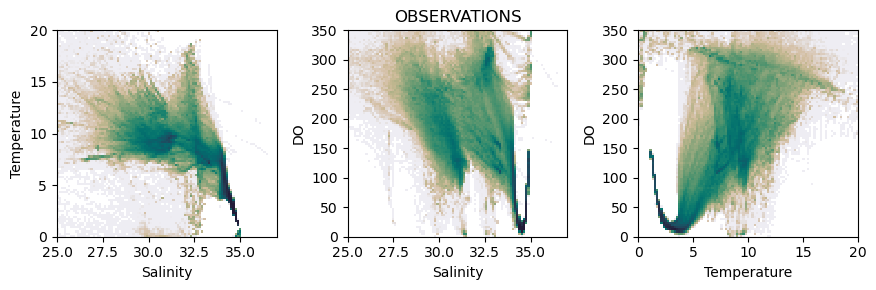

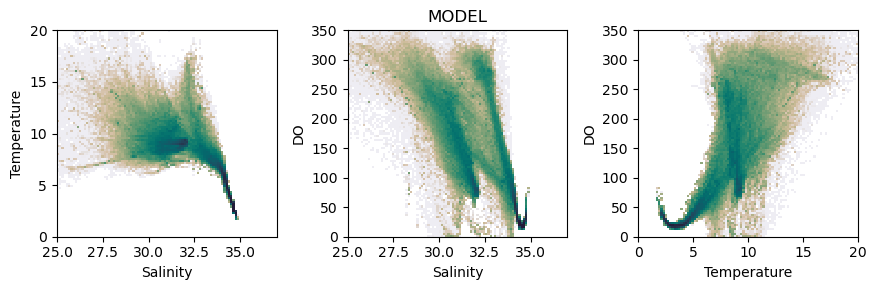

In [33]:
# obs versus model property property plots
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",obs.SA,obs.CT,Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",obs.SA,obs["DO (uM)"],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",obs.CT,obs["DO (uM)"],Tbin,Dbin)
axs[1].set_title('OBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",mod.SA,mod.CT,Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",mod.SA,mod['DO (uM)'],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",mod.CT,mod['DO (uM)'],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()


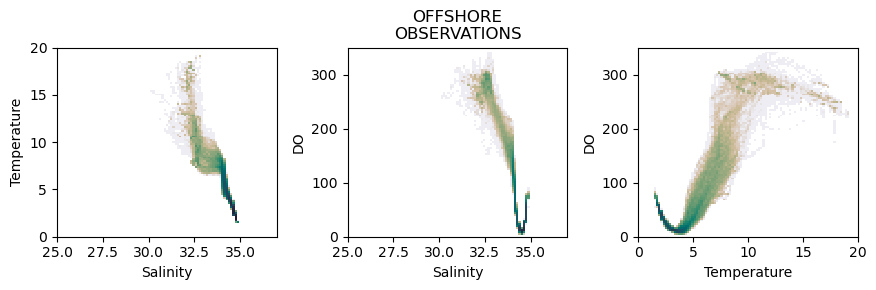

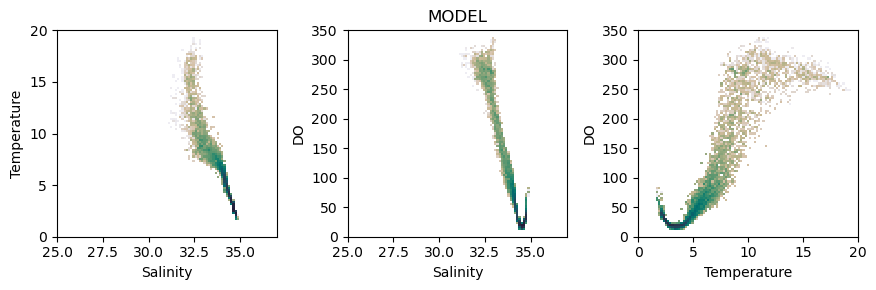

In [34]:
# same thing but by region
#OFFSHORE
r=1

# obs versus model property property plots
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",obs.SA[obs.region == r],obs.CT[obs.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",obs.SA[obs.region == r],obs["DO (uM)"][obs.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",obs.CT[obs.region == r],obs["DO (uM)"][obs.region == r],Tbin,Dbin)
axs[1].set_title('OFFSHORE\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",mod.SA[mod.region == r],mod.CT[mod.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",mod.SA[mod.region == r],mod["DO (uM)"][mod.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",mod.CT[mod.region == r],mod["DO (uM)"][mod.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

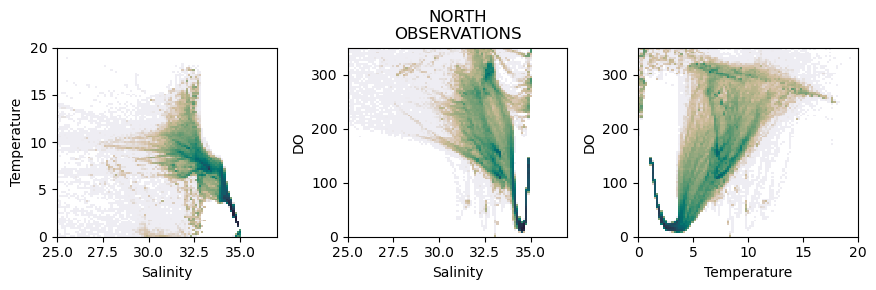

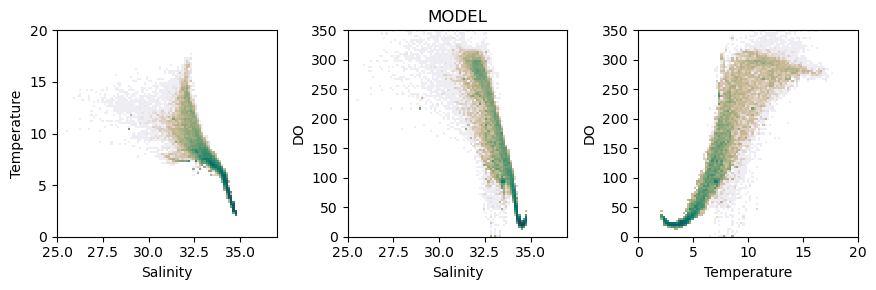

In [35]:
# same thing but by region
r=3
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",obs.SA[obs.region == r],obs.CT[obs.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",obs.SA[obs.region == r],obs["DO (uM)"][obs.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",obs.CT[obs.region == r],obs["DO (uM)"][obs.region == r],Tbin,Dbin)
axs[1].set_title('NORTH\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",mod.SA[mod.region == r],mod.CT[mod.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",mod.SA[mod.region == r],mod["DO (uM)"][mod.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",mod.CT[mod.region == r],mod["DO (uM)"][mod.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

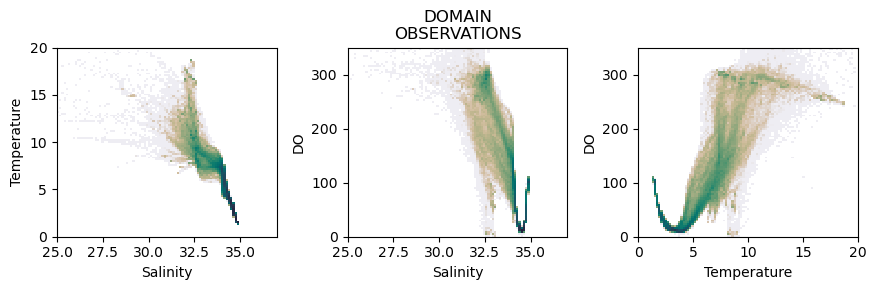

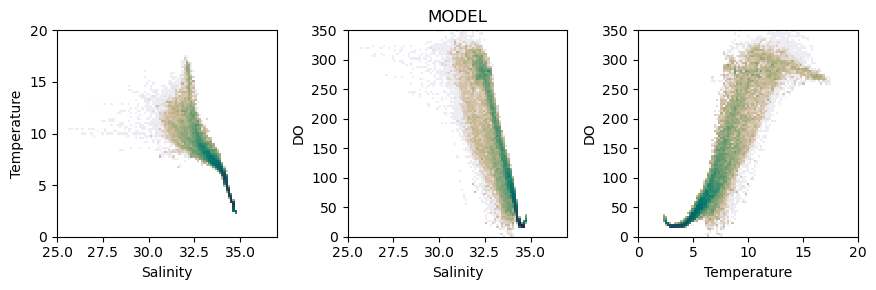

In [36]:
# same thing but by region
r=5
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",obs.SA[obs.region == r],obs.CT[obs.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",obs.SA[obs.region == r],obs["DO (uM)"][obs.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",obs.CT[obs.region == r],obs["DO (uM)"][obs.region == r],Tbin,Dbin)
axs[1].set_title('DOMAIN\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",mod.SA[mod.region == r],mod.CT[mod.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",mod.SA[mod.region == r],mod["DO (uM)"][mod.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",mod.CT[mod.region == r],mod["DO (uM)"][mod.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

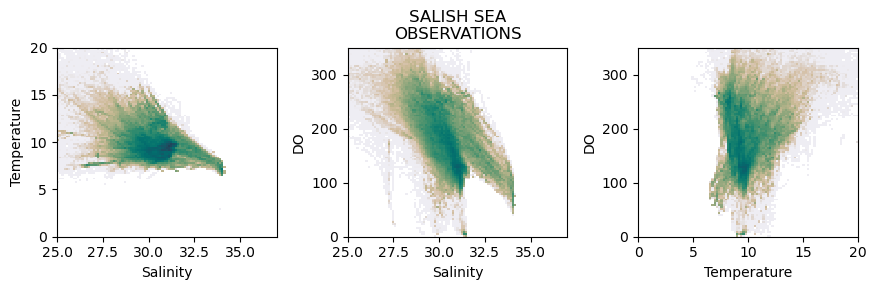

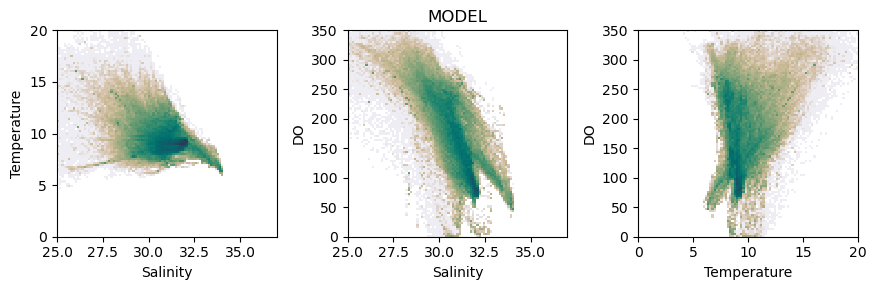

In [37]:
# same thing but by region
r=2
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",obs.SA[obs.region == r],obs.CT[obs.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",obs.SA[obs.region == r],obs["DO (uM)"][obs.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",obs.CT[obs.region == r],obs["DO (uM)"][obs.region == r],Tbin,Dbin)
axs[1].set_title('SALISH SEA\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",mod.SA[mod.region == r],mod.CT[mod.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",mod.SA[mod.region == r],mod["DO (uM)"][mod.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",mod.CT[mod.region == r],mod["DO (uM)"][mod.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

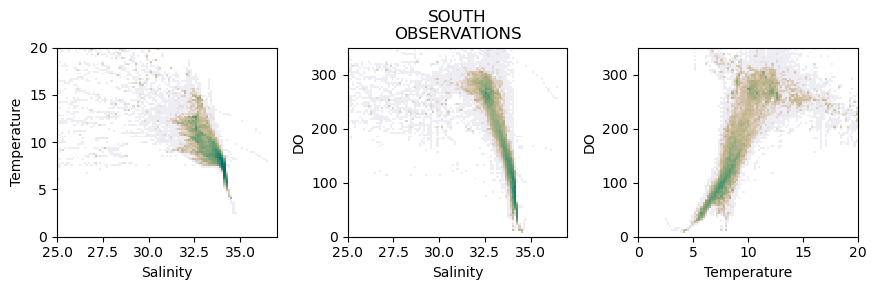

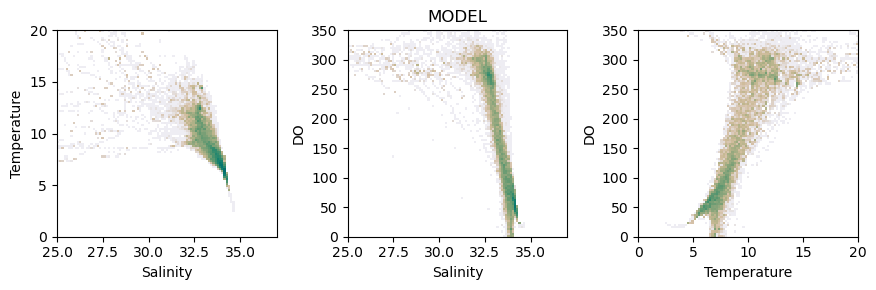

In [38]:
r=4
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

#obs
prop_prop(axs[0],"Salinity","Temperature",obs.SA[obs.region == r],obs.CT[obs.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",obs.SA[obs.region == r],obs["DO (uM)"][obs.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",obs.CT[obs.region == r],obs["DO (uM)"][obs.region == r],Tbin,Dbin)
axs[1].set_title('SOUTH\nOBSERVATIONS')

plt.tight_layout()

# and model
fig, axs = plt.subplots(1, 3, figsize = (9, 3)) 

prop_prop(axs[0],"Salinity","Temperature",mod.SA[mod.region == r],mod.CT[mod.region == r],Sbin,Tbin)
prop_prop(axs[1],"Salinity","DO",mod.SA[mod.region == r],mod["DO (uM)"][mod.region == r],Sbin,Dbin)
prop_prop(axs[2],"Temperature","DO",mod.CT[mod.region == r],mod["DO (uM)"][mod.region == r],Tbin,Dbin)
axs[1].set_title('MODEL')

plt.tight_layout()

# Property profiles by region

In [39]:
import scipy.stats as stat

In [40]:
obs

,cid,lon,lat,time,z,SA,CT,DO (uM),NO3 (uM),Chl (mg m-3),name,cruise,source,NO2 (uM),NH4 (uM),PO4 (uM),SiO4 (uM),TA (uM),DIC (uM),region
0,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-4.858567,29.526436,8.481087,217.480499,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN,2
1,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-25.084826,29.931217,8.744595,194.705338,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN,2
2,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-49.770050,30.161832,8.232655,199.617615,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN,2
3,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-99.627083,31.185733,9.074455,7.145150,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN,2
4,0.0,-123.500336,48.593334,2013-02-06 03:32:28,-148.778397,31.455940,9.045912,5.805434,NaN,NaN,bottle,NaN,dfo1,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4351299,2163.0,-124.180000,44.652000,2018-12-06 20:51:00,-51.573121,33.433898,10.315101,227.938132,NaN,NaN,5,None,NHL,NaN,NaN,NaN,NaN,NaN,NaN,4
4351300,2163.0,-124.180000,44.652000,2018-12-06 20:51:00,-52.564784,33.434924,10.312963,227.487070,NaN,NaN,5,None,NHL,NaN,NaN,NaN,NaN,NaN,NaN,4
4351301,2163.0,-124.180000,44.652000,2018-12-06 20:51:00,-53.556442,33.434945,10.311846,228.563367,NaN,NaN,5,None,NHL,NaN,NaN,NaN,NaN,NaN,NaN,4
4351302,2163.0,-124.180000,44.652000,2018-12-06 20:51:00,-54.548096,33.436976,10.308688,227.393285,NaN,NaN,5,None,NHL,NaN,NaN,NaN,NaN,NaN,NaN,4


In [41]:
def profiles(tracer,r,colour,ax):
    if tracer == 'Salinity':
        t = 'SA'
        unit = 'g/kg'
    elif tracer == 'Temperature':
        t = 'CT'
        unit = '$^{\circ} C$'
    elif tracer == 'DO':
        t = 'DO (uM)'
        unit = 'uM'
    elif tracer == 'NO3':
        t = 'NO3 (uM)'
        unit = 'uM'
    elif tracer == 'TA':
        t = 'TA (uM)'
        unit = 'uM'

    avg_obs, bins, _ = stat.binned_statistic(obs['z'][(obs.region==r)&(np.isfinite(obs[t]))],obs[t][(obs.region==r)&(np.isfinite(obs[t]))],statistic='mean',bins=50)
    avg_mod, bins, _ = stat.binned_statistic(mod['z'][(mod.region==r)&(np.isfinite(mod[t]))],mod[t][(mod.region==r)&(np.isfinite(mod[t]))],statistic='mean',bins=50)

    ax.plot(avg_mod, bins[:-1], c=colour,lw=2,ls='dashed')
    ax.plot(avg_obs, bins[:-1],c=colour,lw=2,label=regions[r-1])

    title = tracer
    ax.set_title(title)
    ax.set_xlabel(unit)
    ax.set_yticks([])
    # ax.set_ylim([-3000,10])


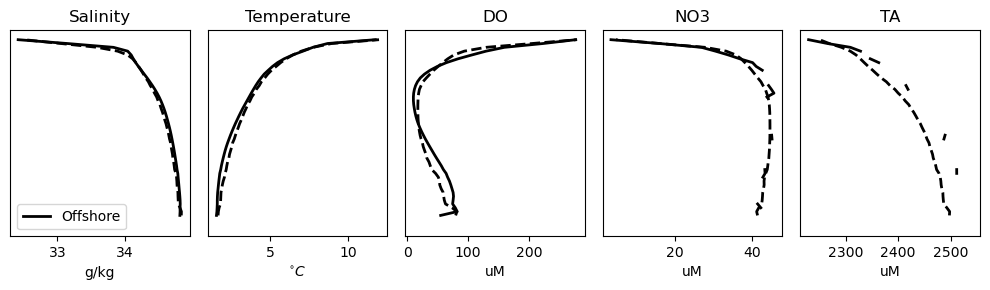

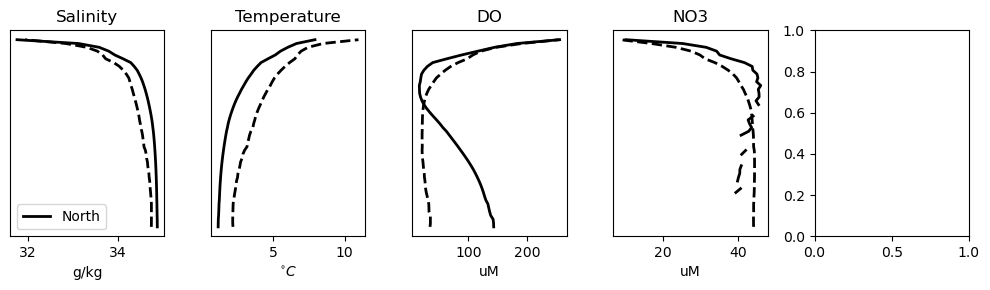

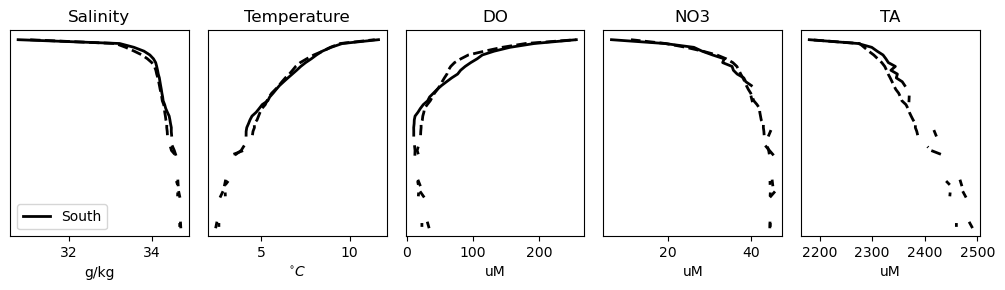

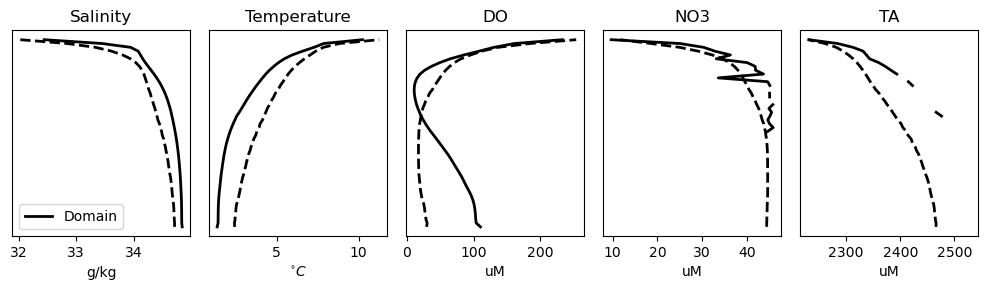

In [42]:
r=1
fig, ax = plt.subplots(1,5, figsize=(10,3))
profiles('Salinity',r,'k',ax[0])
profiles('Temperature',r,'k',ax[1])
profiles('DO',r,'k',ax[2])
profiles('NO3',r,'k',ax[3])
profiles('TA',r,'k',ax[4])
ax[0].legend()
plt.tight_layout()


r=3
fig, ax = plt.subplots(1,5, figsize=(10,3))
profiles('Salinity',r,'k',ax[0])
profiles('Temperature',r,'k',ax[1])
profiles('DO',r,'k',ax[2])
profiles('NO3',r,'k',ax[3])
# profiles('TA','k',r,ax[4])
ax[0].legend()
plt.tight_layout()


r=4
fig, ax = plt.subplots(1,5, figsize=(10,3))
profiles('Salinity',r,'k',ax[0])
profiles('Temperature',r,'k',ax[1])
profiles('DO',r,'k',ax[2])
profiles('NO3',r,'k',ax[3])
profiles('TA',r,'k',ax[4])
ax[0].legend()
plt.tight_layout()


r=5
fig, ax = plt.subplots(1,5, figsize=(10,3))
profiles('Salinity',r,'k',ax[0])
profiles('Temperature',r,'k',ax[1])
profiles('DO',r,'k',ax[2])
profiles('NO3',r,'k',ax[3])
profiles('TA',r,'k',ax[4])
ax[0].legend()

plt.tight_layout()


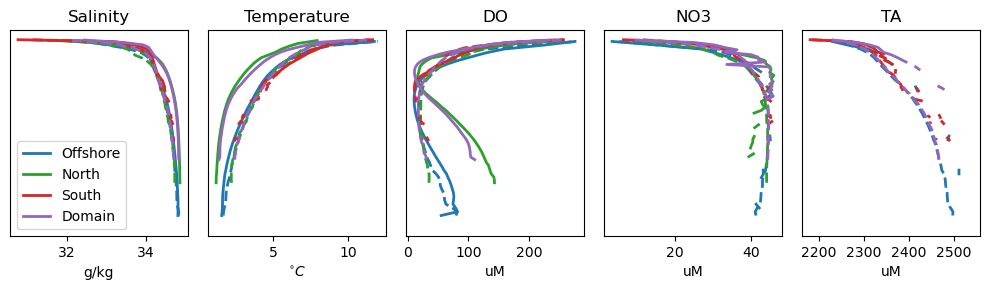

In [43]:
r=1
fig, ax = plt.subplots(1,5, figsize=(10,3))
profiles('Salinity',r,'tab:blue', ax[0])
profiles('Temperature',r,'tab:blue', ax[1])
profiles('DO',r,'tab:blue', ax[2])
profiles('NO3',r,'tab:blue', ax[3])
profiles('TA',r,'tab:blue', ax[4])

r=3
profiles('Salinity',r,'tab:green',ax[0])
profiles('Temperature',r,'tab:green',ax[1])
profiles('DO',r,'tab:green',ax[2])
profiles('NO3',r,'tab:green',ax[3])
# profiles('TA',r,'tab:green',ax[4])

r=4
profiles('Salinity',r,'tab:red',ax[0])
profiles('Temperature',r,'tab:red',ax[1])
profiles('DO',r,'tab:red',ax[2])
profiles('NO3',r,'tab:red',ax[3])
profiles('TA',r,'tab:red',ax[4])

r=5
profiles('Salinity',r,'tab:purple',ax[0])
profiles('Temperature',r,'tab:purple',ax[1])
profiles('DO',r,'tab:purple',ax[2])
profiles('NO3',r,'tab:purple',ax[3])
profiles('TA',r,'tab:purple',ax[4])
ax[0].legend()

plt.tight_layout()

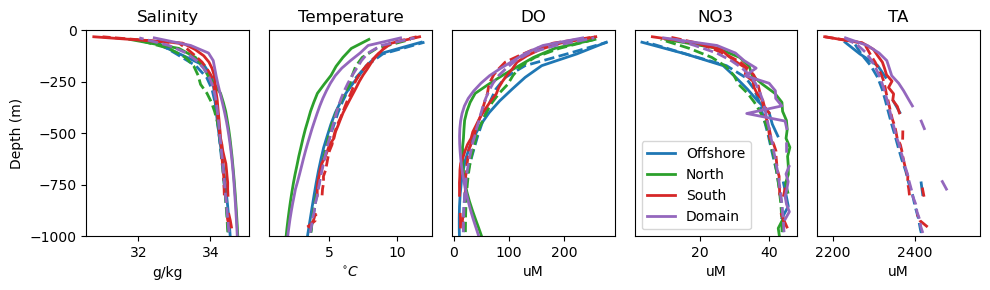

In [44]:
r=1
fig, ax = plt.subplots(1,5, figsize=(10,3))
profiles('Salinity',r,'tab:blue', ax[0])
profiles('Temperature',r,'tab:blue', ax[1])
profiles('DO',r,'tab:blue', ax[2])
profiles('NO3',r,'tab:blue', ax[3])
profiles('TA',r,'tab:blue', ax[4])

r=3
profiles('Salinity',r,'tab:green',ax[0])
profiles('Temperature',r,'tab:green',ax[1])
profiles('DO',r,'tab:green',ax[2])
profiles('NO3',r,'tab:green',ax[3])
# profiles('TA',r,'tab:green',ax[4])

r=4
profiles('Salinity',r,'tab:red',ax[0])
profiles('Temperature',r,'tab:red',ax[1])
profiles('DO',r,'tab:red',ax[2])
profiles('NO3',r,'tab:red',ax[3])
profiles('TA',r,'tab:red',ax[4])

r=5
profiles('Salinity',r,'tab:purple',ax[0])
profiles('Temperature',r,'tab:purple',ax[1])
profiles('DO',r,'tab:purple',ax[2])
profiles('NO3',r,'tab:purple',ax[3])
profiles('TA',r,'tab:purple',ax[4])
ax[3].legend()

ax[0].set_ylabel('Depth (m)')
# ax[0].set_yticks([-500,-400,-300,-200,-100,0])
ax[0].set_yticks(np.linspace(-1000,0,5))

ax[0].set_ylim([-1000,0])
ax[1].set_ylim([-1000,0])
ax[2].set_ylim([-1000,0])
ax[3].set_ylim([-1000,0])
ax[4].set_ylim([-1000,0])
plt.tight_layout()